In [1]:
import pandas as pd
friends_data = pd.read_csv('data/friends.csv')
friends_data.head()

,text,speaker,season,episode,scene,utterance
0,There's nothing to tell! He's just some guy I ...,Monica Geller,1,1,1,1
1,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,1,1,1,2
2,"All right Joey, be nice. So does he have a hum...",Chandler Bing,1,1,1,3
3,"Wait, does he eat chalk?",Phoebe Buffay,1,1,1,4
4,"(They all stare, bemused.)",Scene Directions,1,1,1,5


In [2]:
import re
import nltk
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiaohaotian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xiaohaotian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xiaohaotian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
print(STOPWORDS)
print(len(STOPWORDS))

frozenset({'however', 'found', 'don', 'may', 'please', 'third', 'just', 'former', 'some', 'there', 'interest', 'see', 'bill', 'keep', 'often', 'rather', 'along', 'moreover', 'indeed', 'serious', 'by', 'himself', 'unless', 'perhaps', 'hers', 'couldnt', 'a', 'move', 'these', 'top', 'un', 'become', 'much', 'everything', 'whoever', 'on', 'used', 'kg', 'him', 'yours', 'namely', 'always', 'its', 'make', 'besides', 'whereas', 'nine', 'first', 'where', 'of', 'well', 'behind', 'using', 'ltd', 'here', 'find', 'being', 'co', 'none', 'whose', 'onto', 'itself', 'else', 'regarding', 'whither', 'us', 'already', 'neither', 'was', 'whereupon', 'so', 'our', 'eg', 'amongst', 'further', 'everyone', 'hereafter', 'de', 'call', 'thick', 'hereupon', 'could', 'with', 'mill', 'beyond', 'cannot', 'only', 'per', 'throughout', 'be', 'thereupon', 'sometimes', 'detail', 'below', 'nobody', 'part', 'done', 'me', 'did', 'once', 'now', 'were', 'because', 'amoungst', 'among', 'he', 'than', 'go', 'six', 'sometime', 'somew

In [4]:
friends_data = friends_data.drop(columns=['scene','utterance'], axis=1)
friends_data.head()

,text,speaker,season,episode
0,There's nothing to tell! He's just some guy I ...,Monica Geller,1,1
1,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,1,1
2,"All right Joey, be nice. So does he have a hum...",Chandler Bing,1,1
3,"Wait, does he eat chalk?",Phoebe Buffay,1,1
4,"(They all stare, bemused.)",Scene Directions,1,1


In [5]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
gensim_stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text) # 从文本中删除所有非单词和非空白字
    stop_words = set(gensim_stop_words)
    words = word_tokenize(cleaned_text.lower())
    filtered_words = [word for word in words if word not in stop_words and len(word) >= 4] # 删除少于4个字符的单词
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return lemmatized_words

friends_data['processed_text'] = friends_data['text'].apply(preprocess_text)
friends_data.head()

,text,speaker,season,episode,processed_text
0,There's nothing to tell! He's just some guy I ...,Monica Geller,1,1,"[there, noth, tell, work]"
1,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,1,1,"[cmon, your, go, there, someth, wrong]"
2,"All right Joey, be nice. So does he have a hum...",Chandler Bing,1,1,"[right, joey, nice, hump, hump, hairpiec]"
3,"Wait, does he eat chalk?",Phoebe Buffay,1,1,"[wait, chalk]"
4,"(They all stare, bemused.)",Scene Directions,1,1,"[stare, bemus]"


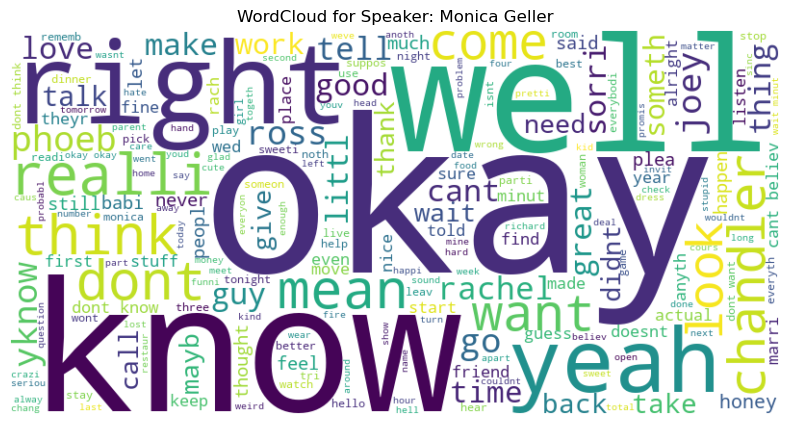

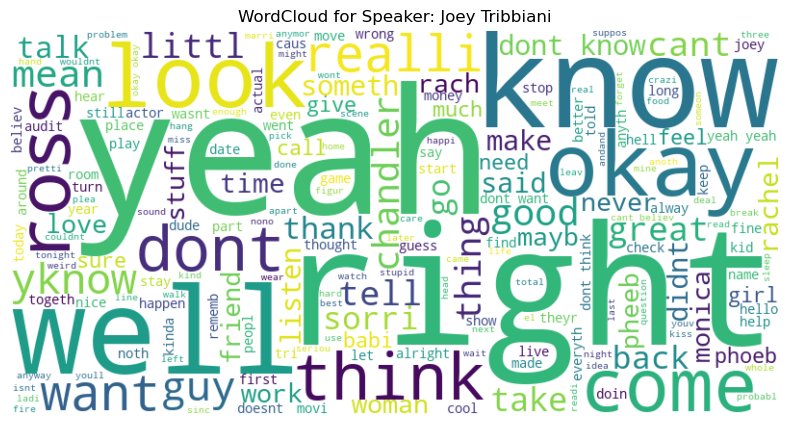

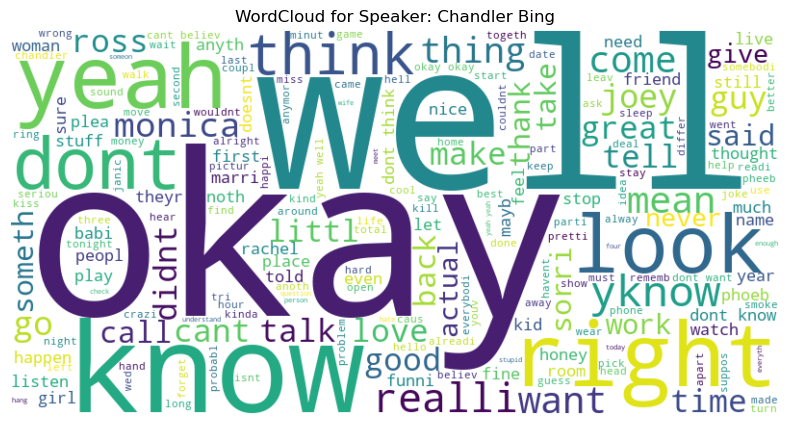

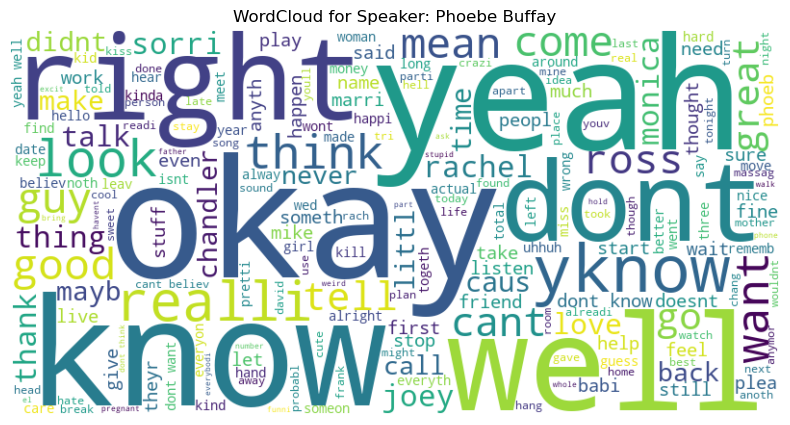

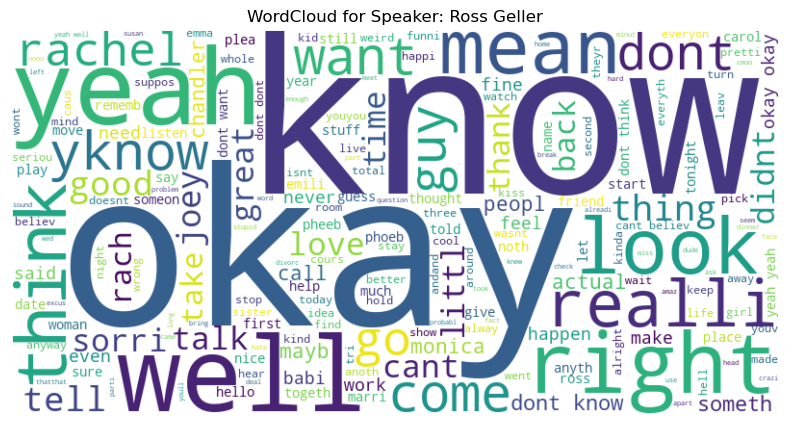

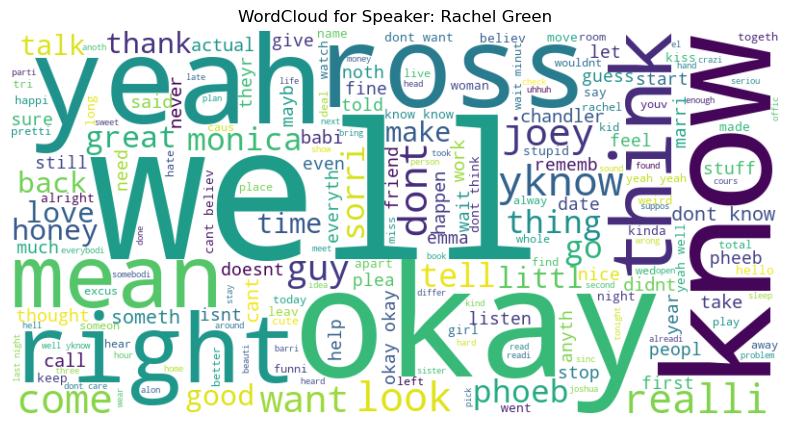

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud_for_speaker(speaker_name, text_data):
    speaker_text = ' '.join(' '.join(tokens) for tokens in text_data[text_data['speaker'] == speaker_name]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(speaker_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Speaker: {speaker_name}')
    plt.show()

speakers_to_visualize = ["Monica Geller", "Joey Tribbiani", "Chandler Bing", "Phoebe Buffay", "Ross Geller", "Rachel Green"]

for speaker_name in speakers_to_visualize:
    generate_wordcloud_for_speaker(speaker_name, friends_data)

In [7]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from pprint import pprint
import numpy as np

id2word = Dictionary(friends_data['processed_text'])
corpus = [id2word.doc2bow(tokens) for tokens in friends_data['processed_text']]

Optimal Number of Topics: 3
Coherence Score for Optimal Number of Topics: 0.5890422144510069


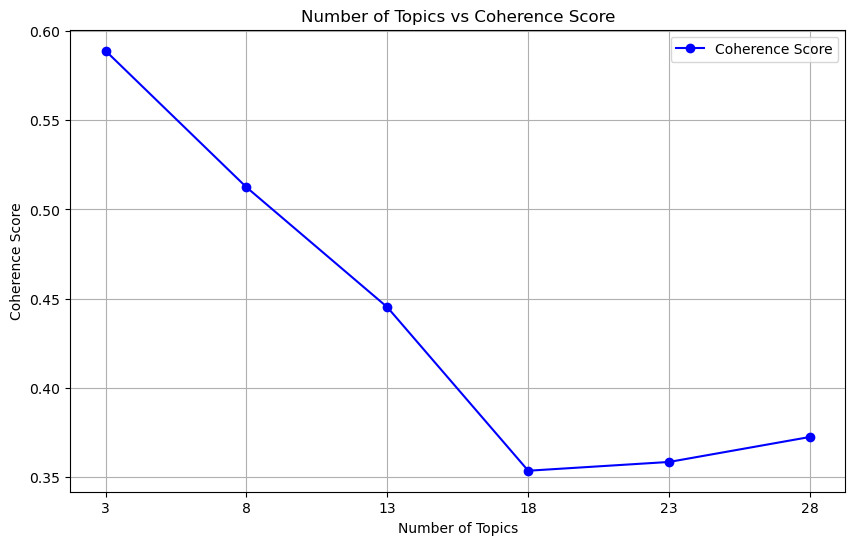

In [8]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt

# 指定要在其中搜索的主题数量范围
min_topics = 3
max_topics = 30
step_size = 5
topics_range = range(min_topics, max_topics + 1, step_size)

coherence_scores = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=friends_data['processed_text'], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

optimal_num_topics = topics_range[np.argmax(coherence_scores)]
print("Optimal Number of Topics:", optimal_num_topics)
print("Coherence Score for Optimal Number of Topics:", max(coherence_scores))

plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o', color='b', label='Coherence Score')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Number of Topics vs Coherence Score')
plt.xticks(topics_range)
plt.legend()
plt.grid(True)
plt.show()

In [9]:
print(coherence_scores)
print(optimal_num_topics)

[0.5890422144510069, 0.512469914774986, 0.44513729211379816, 0.35340084885325723, 0.3583223716505892, 0.3723501748677231]
3


In [10]:
num_topics = 3
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
pprint(lda_model.print_topics())

[(0,
  '0.050*"know" + 0.040*"yeah" + 0.036*"dont" + 0.025*"right" + 0.024*"your" + '
  '0.019*"that" + 0.016*"think" + 0.015*"cant" + 0.014*"well" + 0.014*"want"'),
 (1,
  '0.045*"okay" + 0.034*"scene" + 0.033*"joey" + 0.032*"chandler" + '
  '0.031*"monica" + 0.029*"rachel" + 0.025*"phoeb" + 0.024*"ross" + '
  '0.020*"good" + 0.012*"apart"'),
 (2,
  '0.027*"well" + 0.022*"realli" + 0.016*"go" + 0.015*"time" + 0.015*"like" + '
  '0.013*"thank" + 0.013*"babi" + 0.011*"she" + 0.010*"sure" + 0.010*"take"')]


In [11]:
coherence_model = CoherenceModel(model=lda_model, texts=friends_data['processed_text'], dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.609862815680967


In [12]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os

os.makedirs('results', exist_ok=True)

LDAvis_data_filepath = './results/ldavis_prepared_' + str(num_topics) + '.pkl'

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_' + str(num_topics) + '.html')